#### Build a model to predict liver disease.

### Import Libraries

In [19]:
%load_ext tensorboard
from numpy.random import seed
seed(2)
import tensorflow as tf
from tensorflow import keras
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


### Import Data

In [20]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

liver_dataframe = pd.read_csv("LiverData.csv", sep=",")

liver_dataframe = liver_dataframe.reindex(
np.random.permutation(liver_dataframe.index))

In [21]:
# Check rows and columns
liver_dataframe.shape

(1385, 28)

### Data Preperation

#### Convert target variable 'Class' from string labels to integer:

In [22]:
output_targets = pd.DataFrame(liver_dataframe, columns =["Class"])
output_targets['Class'] = output_targets.Class.astype("category").cat.codes

#### Seperate dataframes for numerical and categorical variables

In [23]:
Categorical_features = pd.DataFrame(liver_dataframe, columns = ["Gender", "Fever", "Nausea/Vomting","Headache ", "Diarrhea ", "Fatigue & generalized bone ache ", "Jaundice ", "Epigastric pain "])
Numerical_features = pd.DataFrame(liver_dataframe, columns = ["Age ","BMI", "WBC", "RBC", "HGB", "Plat", "AST 1", "ALT 1", "ALT4", "ALT 12", "ALT 24", "ALT 36", "ALT 48", "ALT after 24 w", "RNA Base", "RNA 4", "RNA 12", "RNA EOT", "RNA EF"])                               

#### Encode categorical variables

In [24]:
Categorical_features['Gender'] = Categorical_features['Gender'].astype('category').cat.codes
Categorical_features['Fever'] = Categorical_features['Fever'].astype('category').cat.codes
Categorical_features['Nausea/Vomting'] = Categorical_features['Nausea/Vomting'].astype('category').cat.codes
Categorical_features['Headache '] = Categorical_features['Headache '].astype('category').cat.codes
Categorical_features['Diarrhea '] = Categorical_features['Diarrhea '].astype('category').cat.codes
Categorical_features['Fatigue & generalized bone ache '] = Categorical_features['Fatigue & generalized bone ache '].astype('category').cat.codes
Categorical_features['Jaundice '] = Categorical_features['Jaundice '].astype('category').cat.codes
Categorical_features['Epigastric pain '] = Categorical_features['Epigastric pain '].astype('category').cat.codes

#### Train/Validation Split

In [25]:
# Choose the first 1100 examples for training.
training_examples = (pd.concat([Categorical_features, Numerical_features], axis=1, sort=False)).head(1100)
training_target = output_targets.head(1100)

# Normalize the training data
scaler = StandardScaler().fit(training_examples.values)
scaledf = scaler.transform(training_examples.values)
training_examples = pd.DataFrame(scaledf, index=training_examples.index, columns=training_examples.columns)

# Choose 285 examples for validation.
validation_examples = (pd.concat([Categorical_features, Numerical_features], axis=1, sort=False)).tail(285)
validation_target = output_targets.tail(285)

# Normalize the validation data
scaler = StandardScaler().fit(validation_examples.values)
scaledf = scaler.transform(validation_examples.values)
validation_examples = pd.DataFrame(scaledf, index=validation_examples.index, columns=validation_examples.columns)

# Print first few rows of training data:
print("First few rows of training data:")
training_examples.head(10)


First few rows of training data:


,Gender,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,Age,BMI,...,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF
930,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.8,-0.1,...,1.0,0.9,-0.6,-1.0,-0.1,1.2,-0.8,-1.0,-1.1,-1.1
199,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.9,0.1,...,1.5,0.9,1.4,0.5,0.1,1.7,-1.7,0.9,1.8,-0.7
1359,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.3,-1.4,...,-1.0,0.9,-0.3,-0.3,-0.8,-0.7,-0.1,1.6,0.2,1.2
861,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.1,...,-0.4,-0.6,1.1,-1.3,1.6,-1.5,-1.3,-1.0,-1.1,-1.1
387,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-0.7,0.8,...,1.3,1.2,-1.4,-1.2,-1.2,-1.6,-1.5,-1.0,-1.1,-1.1
436,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.3,0.6,...,1.2,-1.6,0.5,0.1,-1.2,-1.6,0.6,0.6,-0.5,-0.1
1364,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.5,-1.6,...,0.9,1.1,-0.3,-0.6,0.1,0.8,1.6,1.3,1.6,1.4
540,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-0.4,1.1,...,-0.5,-0.1,1.2,-0.2,1.5,0.6,-0.8,-0.8,1.4,-0.5
407,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.9,-0.9,...,-1.6,-1.6,-1.0,0.2,0.4,1.4,0.7,0.5,-0.1,1.1
14,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-0.7,0.8,...,0.8,0.2,1.1,1.1,0.4,1.5,1.4,0.4,0.6,-0.6


In [26]:
# Check the baseline:
print("check the distribution of training target:")
frequency = training_target['Class'].value_counts(normalize =True)
print(frequency * 100)

print("check the distribution of validation target:")
frequency = validation_target['Class'].value_counts(normalize =True)
print(frequency * 100)

# Based on the majority classification, baseline would be 26.8

check the distribution of training target:
0   26.8
2   26.7
3   23.9
1   22.5
Name: Class, dtype: float64
check the distribution of validation target:
1   29.5
3   25.6
0   23.5
2   21.4
Name: Class, dtype: float64


### Build Model

In [29]:
baseline_model = keras.Sequential([
    keras.layers.Dense(27, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    keras.layers.Dense(54, activation=tf.nn.relu),
    keras.layers.Dense(54, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
  ])

baseline_model.compile(loss='sparse_categorical_crossentropy',
                optimizer= 'adam',
                metrics=['accuracy'])
baseline_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 27)                756       
_________________________________________________________________
dense_22 (Dense)             (None, 54)                1512      
_________________________________________________________________
dense_23 (Dense)             (None, 54)                2970      
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 220       
Total params: 5,458
Trainable params: 5,458
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [30]:
EPOCHS = 50
early_stopping_monitor = EarlyStopping(monitor = 'val_loss',patience=3)
b_history = baseline_model.fit(training_examples, training_target, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_target), verbose=1,
                    callbacks=[early_stopping_monitor])


Train on 1100 samples, validate on 285 samples
Epoch 1/50
1100/1100 [==============================] - 1s 521us/sample - loss: 1.4095 - accuracy: 0.2373 - val_loss: 1.4010 - val_accuracy: 0.2386
Epoch 2/50
1100/1100 [==============================] - 0s 94us/sample - loss: 1.3682 - accuracy: 0.3027 - val_loss: 1.4087 - val_accuracy: 0.2421
Epoch 3/50
1100/1100 [==============================] - 0s 89us/sample - loss: 1.3462 - accuracy: 0.3455 - val_loss: 1.4106 - val_accuracy: 0.2526
Epoch 4/50
1100/1100 [==============================] - 0s 87us/sample - loss: 1.3281 - accuracy: 0.3736 - val_loss: 1.4136 - val_accuracy: 0.2667


#### Check the minimum and maximum validation accuracy

In [37]:
print("Minimum accuracy of validation: ", min(b_history.history['val_accuracy']))
print("Maximum accuracy of validation: ", max(b_history.history['val_accuracy']))

Minimum accuracy of validation:  0.3122807
Maximum accuracy of validation:  0.34736842


#### Check the minimum and maximum model accuracy

In [38]:
print("Minimum accuracy of Model: ", min(b_history.history['accuracy']))
print("Maximum accuracy of Model: ", max(b_history.history['accuracy']))

Minimum accuracy of Model:  0.24090908
Maximum accuracy of Model:  0.40545455


### Predictions

In [39]:
valpreds = baseline_model.predict_on_batch(validation_examples.iloc[1:10])
print(valpreds)

tf.Tensor(
[[0.4749688  0.1575317  0.18802285 0.17947677]
 [0.18030389 0.25298968 0.31735528 0.24935117]
 [0.25819317 0.21709281 0.27936983 0.24534418]
 [0.25370726 0.1871491  0.33976525 0.21937846]
 [0.31644797 0.09967319 0.3683745  0.21550427]
 [0.22077087 0.15328193 0.31433156 0.31161556]
 [0.19560115 0.34365508 0.22395499 0.2367888 ]
 [0.26274443 0.25131926 0.28861526 0.19732101]
 [0.4204934  0.17313224 0.19056126 0.21581315]], shape=(9, 4), dtype=float32)


In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(validation_target.iloc[1:10])

      Class
1129      0
306       3
415       1
1354      1
1169      2
428       1
186       0
1005      2
908       0


### Plot Results

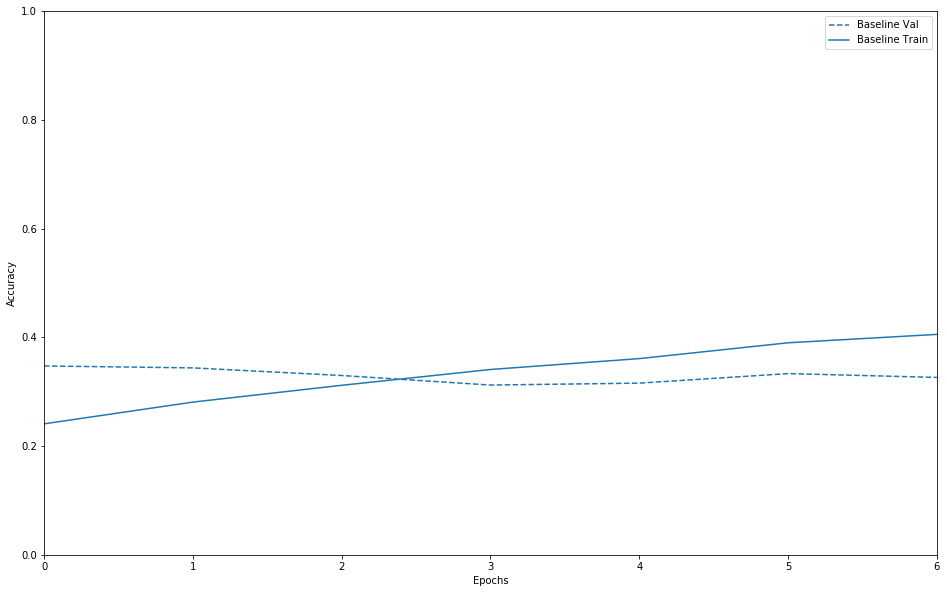

In [42]:
import matplotlib.pyplot as plt


def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0,1])

plot_history([('baseline', b_history)])

  

#### Conclusion:

The output of this model is discrete so the activation function used here is 'softmax', loss function as 'sparse_categorical_crossentropy' , optimizer as 'adam' and metric as 'accuracy'. The baseline for this model is calculated using majority classification rule. The majority class here is 'Cirrhosis' (coded as 0 class). The baseline accuracy is 26.8. The model is able to exceed baseline performance with minimum accuracy of 31% and maximum accuracy of 34%. 